# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2021

<a href="https://colab.research.google.com/github/DiploDatos/AprendizajePorRefuerzos/blob/master/lab_1_intro_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Integrantes:

Arrúa, Esteban

Bernaschini, María Laura

Cámara, Florencia

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por
$$\pi(a \mid s) = 1 - \epsilon$$ si $a$ es la mejor acción, caso contrario $$\pi(a \mid s) = \epsilon$$

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](images/sarsa.png)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](images/q_learning.png)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Librería OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee tres métodos principales:

```reset(self)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, done, info```.

* ```render(self)``` : Muestra en pantalla una parte del ambiente.

* ```close(self)``` : Finaliza con la instancia del agente.

* ```seed(self)``` : Establece la semilla aleatoria del generador de números aleatorios del presente entorno.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```sudo apt-get install ffmpeg```


desde Windows descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

Código básico de importación y funciones de graficación (no modificar)

In [71]:
#@title Código básico de graficación (no modificar)

import sys
sys.path.append('c:/users/arrua/appdata/roaming/python/python39/site-packages')

import gym


import numpy as np
import matplotlib.pyplot as plt
import itertools
import gym
import random

def plot_reward_per_episode(reward_ep):

    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

    plt.plot(reward_per_episode)
    plt.title('Recompensa acumulada por episodio')
    plt.show()
    
    
def plot_steps_per_episode(timesteps_ep):
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title('Pasos (timesteps) por episodio')
    plt.show()
    
    
def plot_steps_per_episode_smooth(timesteps_ep):
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [acumulated_steps[i] / episode_number[i] for i in range(len(acumulated_steps))]

    plt.plot(steps_per_episode)
    plt.title('Pasos (timesteps) acumulados por episodio')
    plt.show()
    

def draw_value_matrix(q):

    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):

            state_values = []

            for action in range(n_actions):
                state_values.append(q.get((row * n_columns + column, action), -100))

            maximum_value = max(state_values)  # determinamos la acción que arroja máximo valor


            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar) para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])):

        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = 'D'
        best_action = down_action

        if best_action < right_action:
            arrow_direction = 'R'
            best_action = right_action
        if best_action < left_action:
            arrow_direction = 'L'
            best_action = left_action
        if best_action < up_action:
            arrow_direction = 'U'
            best_action = up_action
        if best_action == -1:
            arrow_direction = ''

        # notar que column, row están invertidos en orden en la línea de abajo porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print('\n Matriz de mejor acción-valor (en números): \n\n', q_value_matrix)

# Ejemplo 1: The Cliff. 


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$



Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la **política de exploración $\epsilon$-greedy**.

In [72]:
def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = q[state,:]  # ej: para 4 acciones inicializa en [0,0,0,0]
    
    max_q =[]

    if random_state.uniform() < epsilon:  # sorteamos un número: es menor a épsilon?
        return random_state.choice(actions)  # sí: se selecciona una acción aleatoria


    for i in range(0,len(q_values),1):      #Elegimos la acción que mayor valor tiene
        if q_values[i]==np.max(q_values):
            max_q.append(i)
    
    count = len(max_q)   #Pueden haber dos acciones con el mismo valor de q

    
    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        # best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(max_q)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = max_q[0]

    
    return actions[i]

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

Como se plantea para los ejercicios 1 y 2, se define el método learn para SARSA y para Q-Learning.

## **Ejercicio 1**

In [73]:
#Definimos el método learn para SARSA
def learn_sarsa(state, action, reward, next_state, next_action):

  predict = q[state, action]

  target = reward + gamma * q[next_state, next_action]
    
  q[state, action] = q[state, action] + alpha * (target- predict)
  
  pass
    

Finalmente, definimos el método principal de iteraciones. 

In [74]:
def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    timesteps_of_episode = []  # registro de la cantidad de pasos que le llevó en cada episodio
    reward_of_episode = []  # cantidad de recompensa que recibió el agente en cada episodio

    for i_episode in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo llega a la salida
        # o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual
        action = choose_action(state)
        
        while not done:

            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)
            

            episode_reward += reward
            learn_sarsa(state, action, reward, next_state, next_action)

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [75]:
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = np.zeros((env.observation_space.n, env.action_space.n))

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

In [76]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

#### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

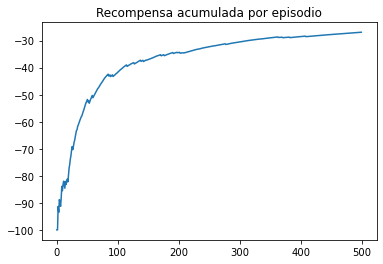

In [77]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

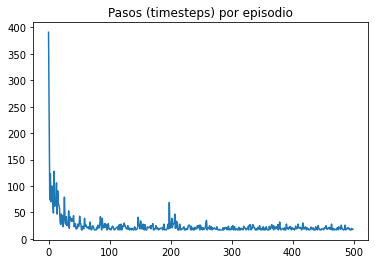

In [78]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

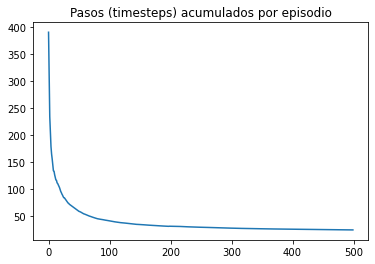

In [79]:
plot_steps_per_episode_smooth(timesteps_ep)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

In [80]:
env.close()

## **Ejercicio 2**

In [81]:
def learn_q(state, action, reward, next_state):

    """
    Esta función implementa el algoritmo de aprendizaje Q-learning
    
    """

    q[state, action] = q[state, action] + alpha * (reward + gamma * np.max(q[next_state, :])- q[state, action])

    pass

In [82]:
def run_q():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    timesteps_of_episode = []  # registro de la cantidad de pasos que le llevó en cada episodio
    reward_of_episode = []  # cantidad de recompensa que recibió el agente en cada episodio

    for i_episode in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo llega a la salida
        # o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

               
        while not done:

            # el agente ejecuta la acción elegida y obtiene los resultados
            # elige una acción basado en el estado actual
            action = choose_action(state) 
            
            next_state, reward, done, info = env.step(action)
            
                     

            episode_reward += reward
            learn_q(state, action, reward, next_state)

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                state = next_state
                
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [83]:
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = np.zeros((env.observation_space.n, env.action_space.n))

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500


# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [84]:
avg_steps_per_episode, timesteps_ep, reward_ep = run_q()

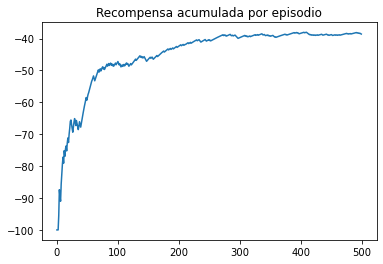

In [85]:
plot_reward_per_episode(reward_ep)

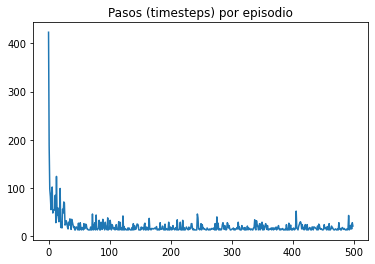

In [86]:
plot_steps_per_episode(timesteps_ep)

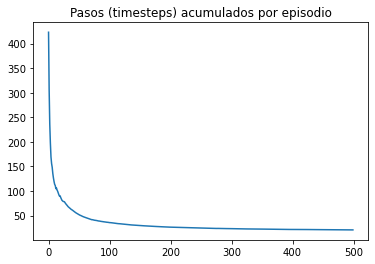

In [87]:
plot_steps_per_episode_smooth(timesteps_ep)

A partir de los gráficos podemos observar que el algoritmo de Q-learning converge más rápido que el de SARSA, esto se puede evidenciar en la menor cantidad de pasos por episodio y en la acumulación más rápida de recompensas por parte de Q-Learning. Esto se debe a que el algoritmo de SARSA es mucho más conservador ya que penaliza los movimientos exploratorios, mientras que Q-Learning los ignora. Si existe el riesgo de una recompensa negativa grande cerca del camino óptimo, Q-learning tenderá a activar esa recompensa mientras explora, mientras que SARSA tenderá a evitar un camino óptimo peligroso y solo aprenderá lentamente a usarlo. 

## **Ejercicio 3**

Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

Continuamos trabajando sobre el ejemplo del Ejercicio 2, tomando un algoritmo de aprendizaje Q-learning, y probamos distintos valores extremos para cada hiperparámetro, manteniendo los demás constantes.

### a. Distintos valores del parámetro $\alpha$ (learning rate)

Es la medida en la cual se actualizan los valores de Q en cada iteración. Es esperable que a valores mas grandes, la convergencia sea mas rápida

Alpha igual 1 (alto?)

In [88]:
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = np.zeros((env.observation_space.n, env.action_space.n))

# definimos sus híper-parámetros básicos

alpha = 1      ## Modifico este parámetro
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500


# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [89]:
avg_steps_per_episode, timesteps_ep, reward_ep = run_q()

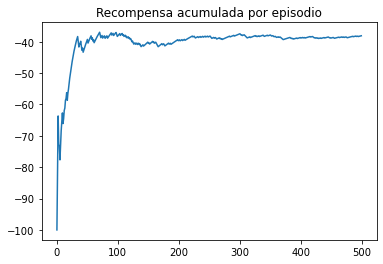

In [90]:
plot_reward_per_episode(reward_ep)

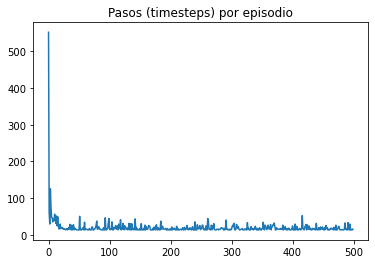

In [91]:
plot_steps_per_episode(timesteps_ep)

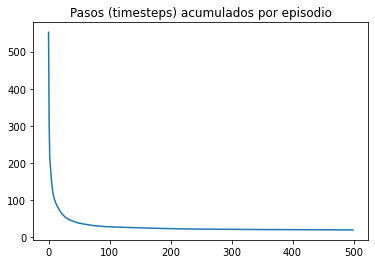

In [92]:
plot_steps_per_episode_smooth(timesteps_ep)

Bajo alpha

In [93]:
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = np.zeros((env.observation_space.n, env.action_space.n))

# definimos sus híper-parámetros básicos

alpha = 0.1      ## Modifico este parámetro
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500


# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [94]:
avg_steps_per_episode, timesteps_ep, reward_ep = run_q()

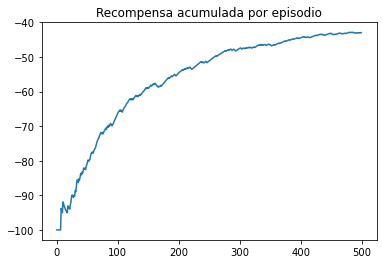

In [95]:
plot_reward_per_episode(reward_ep)

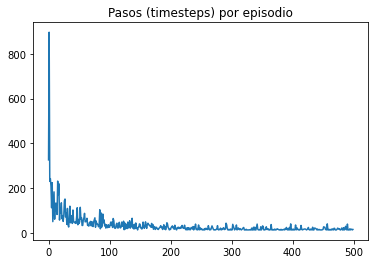

In [96]:
plot_steps_per_episode(timesteps_ep)

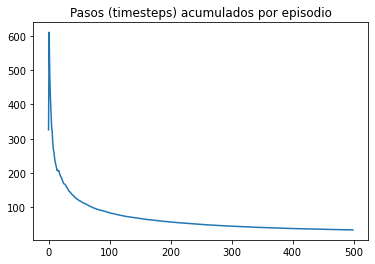

In [97]:
plot_steps_per_episode_smooth(timesteps_ep)

**Conclusión**

Dados todos los demás parámetros constantes, a menor valor del parámetro $\alpha$, la convergencia es más lenta. Esto se debe a que los pasos de optimización del algoritmo son más cortos lo que determina un mayor tiempo en el proceso de convergencia.  

### b. Distintos valores de parámetro $\epsilon$ 

En este caso damos mayor importancia a la exploración o a la eleccion basada en Q values de acciones ya conocidas. Es esperable que al aumentar el valor de epsilon, la probabilidad de elegir acciones aleatorias aumente y con ello las penalidades.

Alto épsilon

In [98]:
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = np.zeros((env.observation_space.n, env.action_space.n))

# definimos sus híper-parámetros básicos

alpha = 0.5      
gamma = 1
epsilon = 0.8      ## Modifico este parámetro
tau = 25

episodes_to_run = 500


# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [99]:
avg_steps_per_episode, timesteps_ep, reward_ep = run_q()

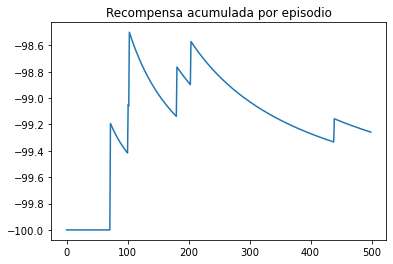

In [100]:
plot_reward_per_episode(reward_ep)

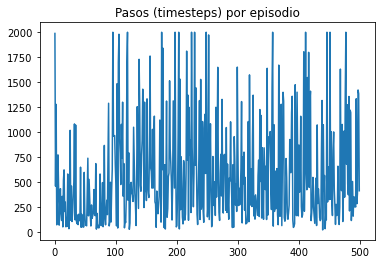

In [101]:
plot_steps_per_episode(timesteps_ep)

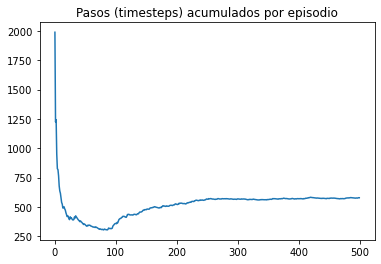

In [102]:
plot_steps_per_episode_smooth(timesteps_ep)

Bajo épsilon

In [103]:
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = np.zeros((env.observation_space.n, env.action_space.n))

# definimos sus híper-parámetros básicos

alpha = 0.5      
gamma = 1
epsilon = 0    ## Modifico este parámetro
tau = 25

episodes_to_run = 500


# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [104]:
avg_steps_per_episode, timesteps_ep, reward_ep = run_q()

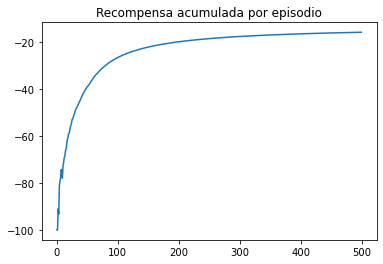

In [105]:
plot_reward_per_episode(reward_ep)

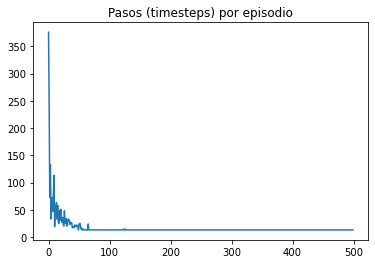

In [106]:
plot_steps_per_episode(timesteps_ep)

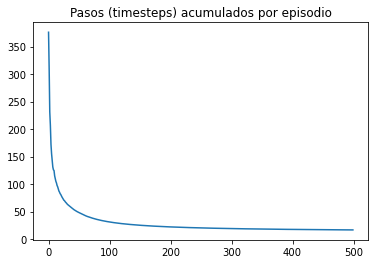

In [107]:
plot_steps_per_episode_smooth(timesteps_ep)

**Conclusión**

Dados todos los demás parámetros constantes, a menor valor del parámetro $\epsilon$, la convergencia es más rápida. Dado que en el tipo de política planteado $\epsilon$ se encuentra definida como la probabilidad asociada a la elección de una acción aleatoria (y su complemento esta asociada a la elección de la mejor acción), mientras mayor sea la probabilidad determinada para la elección de la mejor acción (y menor la probabilidad asociada a la elección aleatoria), más rápida será la convergencia.

### c. Distintos valores del parámetro $\gamma$

Alto gamma

In [108]:
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = np.zeros((env.observation_space.n, env.action_space.n))

# definimos sus híper-parámetros básicos

alpha = 0.5      
gamma = 1.5           ## Modifico este parámetro
epsilon = 0.1
tau = 25

episodes_to_run = 500


# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [109]:
avg_steps_per_episode, timesteps_ep, reward_ep = run_q()

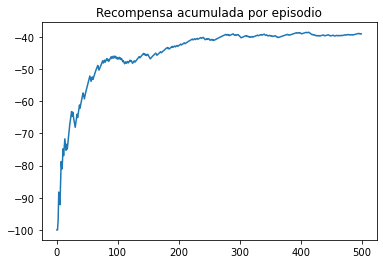

In [110]:
plot_reward_per_episode(reward_ep)

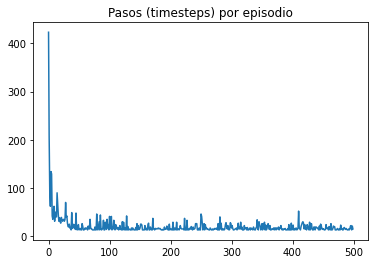

In [111]:
plot_steps_per_episode(timesteps_ep)

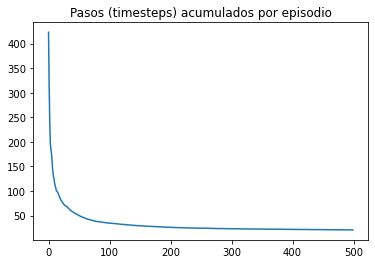

In [112]:
plot_steps_per_episode_smooth(timesteps_ep)

Bajo gamma

In [113]:
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = np.zeros((env.observation_space.n, env.action_space.n))

# definimos sus híper-parámetros básicos

alpha = 0.5      
gamma = 0.2      ## Modifico este parámetro
epsilon = 0.1
tau = 25

episodes_to_run = 500


# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [114]:
avg_steps_per_episode, timesteps_ep, reward_ep = run_q()

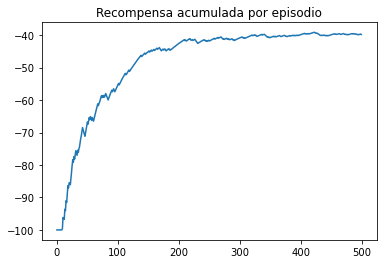

In [115]:
plot_reward_per_episode(reward_ep)

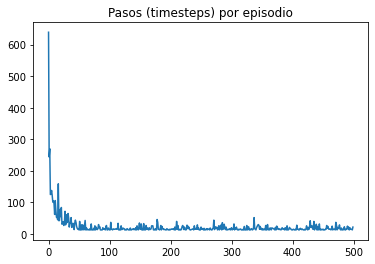

In [116]:
plot_steps_per_episode(timesteps_ep)

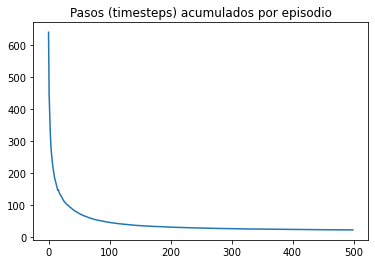

In [117]:
plot_steps_per_episode_smooth(timesteps_ep)

**Conclusión**

Dados todos los demás parámetros constantes, a menor valor del parámetro $\gamma$, la convergencia es más rápida. Esto se debe a que los valores pequeños de gamma le dan más importancia a las recompensas actuales que a las futuras determinando un menor tiempo de exploración del agente.

### Búsqueda de parámetros
Alternativamente, se hizo un grid search con distintos parámetros. Se ha intentado optimizar el ratio reward_ep/timesteps_ep, porque se busca la mayor recompensa en el menor tiempo posible. Otro aspecto a tener en cuenta son las penalidades por episodio.

In [120]:
def run_q_grid():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    timesteps_of_episode = []  # registro de la cantidad de pasos que le llevó en cada episodio
    reward_of_episode = []  # cantidad de recompensa que recibió el agente en cada episodio
    total_penalties=[]

    for i_episode in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo llega a la salida
        # o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0
        penalties=0

               
        while not done:

            # el agente ejecuta la acción elegida y obtiene los resultados
            # elige una acción basado en el estado actual
            action = choose_action(state) 
            
            next_state, reward, done, info = env.step(action)
            
            if reward==-100:
                penalties=penalties+1         

            episode_reward += reward
            learn_q(state, action, reward, next_state)

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                state = next_state
                
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1
        total_penalties.append(penalties)

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode,np.mean(total_penalties)

In [123]:
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = np.zeros((env.observation_space.n, env.action_space.n))

# definimos sus híper-parámetros básicos

alpha = 0.5      
gamma = 0.2      ## Modifico este parámetro
epsilon = 0.1
tau = 25

episodes_to_run = 500


# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [124]:
# GridSearch

from sklearn.model_selection import ParameterGrid

hiperparametros={'alpha':[0.001,0.01,0.1,0.5,0.9],
                 'gamma': [0.01,0.1,0.5,0.9],
                 'epsilon': [0.1,0.2,0.3,0.4]}

hiper=list(ParameterGrid(hiperparametros))

# Como es deseable obtener la recompensa máxima en el menor tiempo, definimos el
# ratio reward/timesteps, que es el parámetro a optimizar, junto con 
# el número de penalidades

ratios=[]
penalties_=[]

for parameter in hiper:
    
    env = gym.make("CliffWalking-v0")
    actions = range(env.action_space.n)
    q = np.zeros((env.observation_space.n, env.action_space.n))
    
    alpha=parameter['alpha']
    gamma=parameter['gamma']
    epsilon=parameter['epsilon']
    
    avg_steps_per_episode, timesteps_ep, reward_ep, penalties = run_q_grid()
    
    ratio=np.mean(reward_ep)/np.mean(timesteps_ep)
    
    ratios.append(ratio)
    penalties_.append(penalties)

print("La configuración más óptima es: {} con ratio {} y penalidades {}".format(hiper[ratios.index(max(ratios))],
                                                                                ratios[ratios.index(max(ratios))],
                                                                                penalties_[ratios.index(max(ratios))]))

La configuración más óptima es: {'alpha': 0.001, 'epsilon': 0.4, 'gamma': 0.01} con ratio -0.0851664974515173 y penalidades 33.472


In [125]:
import pandas as pd

pd.DataFrame([hiper,ratios,penalties_]).T.rename(columns={0:'Hiperparámetros',1:'Ratio',2:'penalidades'}).sort_values(['Ratio','penalidades'],ascending=[False,True])

,Hiperparámetros,Ratio,penalidades
12,"{'alpha': 0.001, 'epsilon': 0.4, 'gamma': 0.01}",-0.0851665,33.472
8,"{'alpha': 0.001, 'epsilon': 0.3, 'gamma': 0.01}",-0.0948828,22.164
13,"{'alpha': 0.001, 'epsilon': 0.4, 'gamma': 0.1}",-0.100196,27.958
4,"{'alpha': 0.001, 'epsilon': 0.2, 'gamma': 0.01}",-0.114755,11.996
9,"{'alpha': 0.001, 'epsilon': 0.3, 'gamma': 0.1}",-0.115451,17.736
...,...,...,...
74,"{'alpha': 0.9, 'epsilon': 0.3, 'gamma': 0.5}",-2.04104,1.518
55,"{'alpha': 0.5, 'epsilon': 0.2, 'gamma': 0.9}",-2.12839,0.884
69,"{'alpha': 0.9, 'epsilon': 0.2, 'gamma': 0.1}",-2.19731,0.83
70,"{'alpha': 0.9, 'epsilon': 0.2, 'gamma': 0.5}",-2.21435,0.874


En este caso vemos que los hiperparámetros elegidos coinciden con los que generan mayores penalidades (mayor probabilidad epsilon, mayor exploración.). Sin embargo, el segundo criterio (epsilon=0.3) también sería un buen candidato

**Ejercicio 4** 

**Política SOFTMAX**

En este caso se usa el hiperparámetro tau para ponderar los valores de Q y proporcionar una probabilida de seleccionar una acción. Cuando tau es alto, la probabilidad de todas las acciones será la misma, mientras que cuando sea baja, aún una pequeña diferencia en Q(s,ai) hará una gran diferencia de probabilidad de seleccionar la acción ai. Básicamente tiende a enfocar el afente en explorar las diferencias entre acciones de calificación alta similar.

In [61]:
def policy_softmax(state, tau):

    p = np.array([q[(state,x)]/tau for x in range(env.action_space.n)])
    prob_actions = np.exp(p) / np.sum(np.exp(p))
    cumulative_probability = 0.0
    choice = random.uniform(0,1)
    for action,pr in enumerate(prob_actions):
        cumulative_probability += pr
        if cumulative_probability > choice:
            return action

In [62]:
def run_q_softmax():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    timesteps_of_episode = []  # registro de la cantidad de pasos que le llevó en cada episodio
    reward_of_episode = []  # cantidad de recompensa que recibió el agente en cada episodio

    for i_episode in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo llega a la salida
        # o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

               
        while not done:

            # el agente ejecuta la acción elegida y obtiene los resultados
            # elige una acción basado en el estado actual
            action = policy_softmax(state,tau) 
            
            next_state, reward, done, info = env.step(action)
            
                     

            episode_reward += reward
            learn_q(state, action, reward, next_state)

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                state = next_state
                
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [66]:
env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = np.zeros((env.observation_space.n, env.action_space.n))

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 0.2

episodes_to_run = 500

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [67]:
avg_steps_per_episode, timesteps_ep, reward_ep = run_q_softmax()

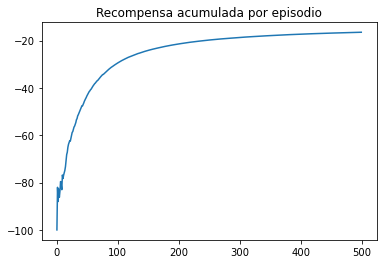

In [68]:
plot_reward_per_episode(reward_ep)

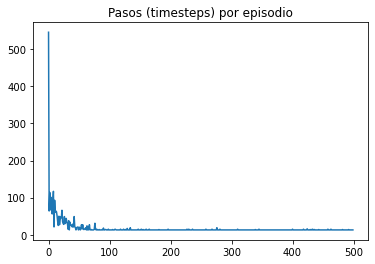

In [69]:
plot_steps_per_episode(timesteps_ep)

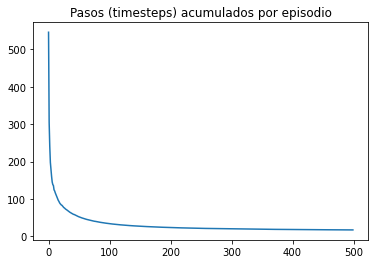

In [70]:
plot_steps_per_episode_smooth(timesteps_ep)

La función de recompensa tiene un crecimiento mas suave con respecto a la política epsilon greedy. Esto se debe a que la misma trabaja en el dominio continuo.